In [32]:
# Data handling
import pandas as pd
import numpy as np

# Text preprocessing
import re
import string

# Model building
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix


In [33]:
# Load dataset
df = pd.read_csv('/content/sentiment_tweets3.csv')

# Display first few rows
df.head()


,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      10314 non-null  int64 
 1   message to examine         10314 non-null  object
 2   label (depression result)  10314 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 241.9+ KB


In [35]:
df.isnull().sum()

,0
Index,0
message to examine,0
label (depression result),0


Data Cleaning (Text Preprocessing)

In [36]:
df.columns

Index(['Index', 'message to examine', 'label (depression result)'], dtype='object')

In [37]:
# Rename columns to clean, usable names
df = df.rename(columns={
    'message to examine': 'text',
    'label (depression result)': 'label'
})

# Drop useless index column
df = df.drop(columns=['Index'])

df.head()


,text,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [38]:
import re

# Function to clean text
def clean_text(text):
    text = text.lower()                      # Lowercase
    text = re.sub(r"http\S+", "", text)      # Remove URLs
    text = re.sub(r"[^a-z\s]", "", text)     # Remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip() # Remove extra spaces
    return text

# Apply cleaning
df['clean_text'] = df['text'].astype(str).apply(clean_text)


Cleaning improves signal clarity

Simpler preprocessing is often better

In [39]:
df['label'].value_counts()


,count
label,
0,8000
1,2314


In [40]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])


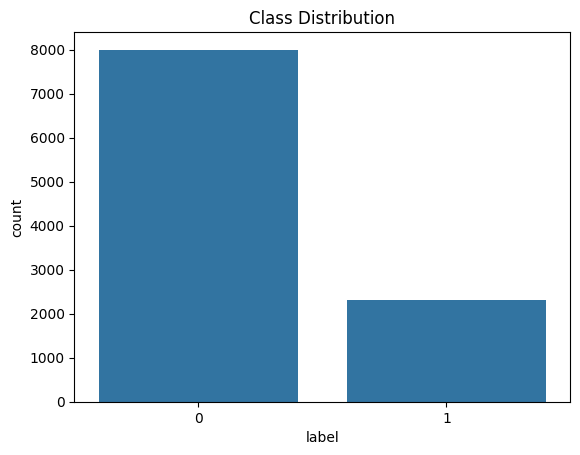

In [41]:
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.show()


Text Cleaning Function

In [42]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    return text

df['text'] = df['text'].apply(clean_text)

In [43]:
#feature extraction
X = df['text']
y = df['label']

vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=5000
)

X_tfidf = vectorizer.fit_transform(X)

In [44]:
#splitting into test and training
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [45]:
#convert text into numerical vectors
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [46]:
#model training
svm_model = LinearSVC(class_weight='balanced')

svm_model.fit(X_train_tfidf, y_train)


LinearSVC(class_weight='balanced')

In [47]:
#evaluation of it
# Predictions
y_pred = svm_model.predict(X_test_tfidf)

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))


[[1596    4]
 [   9  454]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1600
           1       0.99      0.98      0.99       463

    accuracy                           0.99      2063
   macro avg       0.99      0.99      0.99      2063
weighted avg       0.99      0.99      0.99      2063



#Graph representations

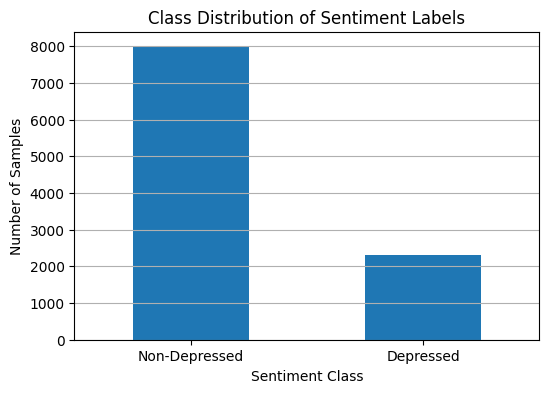

In [50]:
# Class distribution
class_counts = df['label_encoded'].value_counts()

plt.figure(figsize=(6,4))
class_counts.plot(kind='bar')

plt.title('Class Distribution of Sentiment Labels')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Samples')
plt.xticks([0,1], ['Non-Depressed', 'Depressed'], rotation=0)
plt.grid(axis='y')

plt.show()

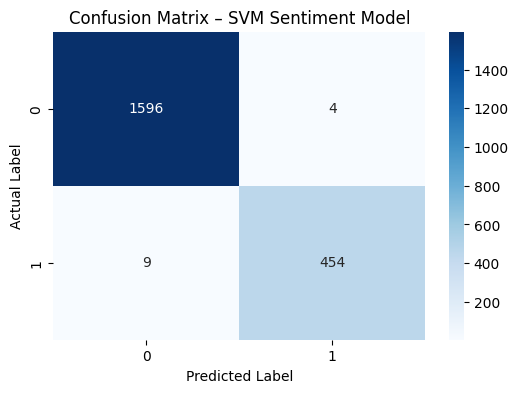

In [51]:
#model makes very few false predictions
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Confusion Matrix – SVM Sentiment Model')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

plt.show()



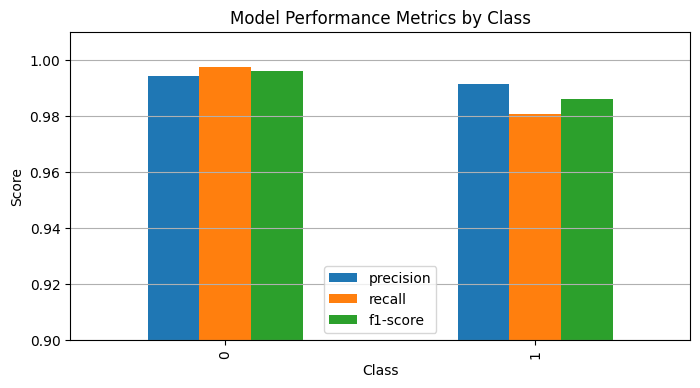

In [52]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df[['precision', 'recall', 'f1-score']].iloc[:2].plot(
    kind='bar',
    figsize=(8,4)
)

plt.title('Model Performance Metrics by Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim(0.9, 1.01)
plt.grid(axis='y')

plt.show()


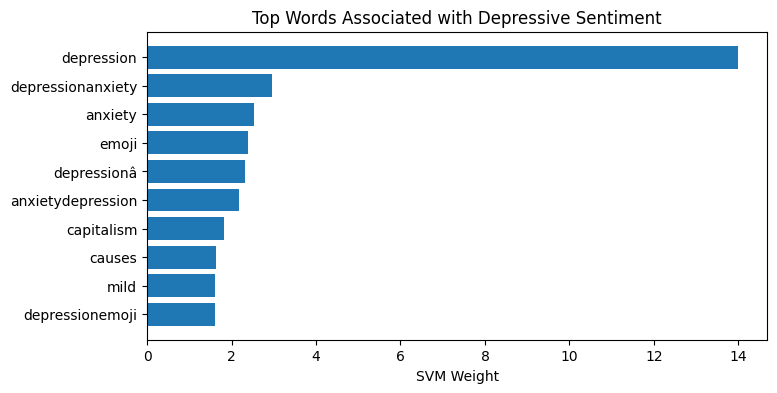

In [54]:
# Get feature names from TF-IDF
feature_names = tfidf.get_feature_names_out()

# Get SVM coefficients (already a NumPy array)
coefficients = svm_model.coef_[0]

# Create dataframe for interpretation
coef_df = pd.DataFrame({
    'word': feature_names,
    'weight': coefficients
})

# Select top words linked to depressive sentiment
top_words = coef_df.sort_values(by='weight', ascending=False).head(10)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.barh(top_words['word'], top_words['weight'])
plt.title('Top Words Associated with Depressive Sentiment')
plt.xlabel('SVM Weight')
plt.gca().invert_yaxis()

plt.show()


In [55]:
#extracting the models
import joblib

joblib.dump(svm_model, 'sentiment_svm_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']